In [1]:
library(ggplot2)
library(dplyr)
library(ggmap)
library(maps)
library(mapdata)
library(lubridate)
options(jupyter.plot_mimetypes = 'image/png')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Google Maps API Terms of Service: http://developers.google.com/maps/terms.
Please cite ggmap if you use it: see citation("ggmap") for details.

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [2]:
path <- "../google_transit"
extension <- ".txt"
files <- c("agency", "calendar_dates", "calendar", "fare_attributes", "fare_rules",
           "feed_info", "frequencies", "place_patterns", "places", "routes", "shapes", 
           "stop_times", "stops", "transfers", "trips")

GTFSlist <- list()

for (i in 1:length(files)) {
  df <- read.csv(file=file.path(path, paste(files[i], extension, sep="")), header=T)
  GTFSlist[[i]] <- df
}

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../google_transit/agency.txt'”Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../google_transit/calendar.txt'”Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../google_transit/feed_info.txt'”Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../google_transit/frequencies.txt'”

# Static Data
## Quick Reference 
### GTFSlist indices
1.   Agency 
2.   Calendar Dates
3.   Calendar
4.   Fare Attributes
5.   Fare Rules
6.   Feed Info
7.   Frequencies
8.   Place Patterns
9.   Places
10.   Routes
11.   Shapes
12.  Stop Times
13.  Stops
14.  Transfers
15.  Trips

In [3]:
#agency <-          GTFSlist[[1]]
#calendar_dates <-  GTFSlist[[2]]
#calendar <-        GTFSlist[[3]]
#fare_attributes <- GTFSlist[[4]]
#fare_rules <-      GTFSlist[[5]]
#feed_info <-       GTFSlist[[6]]
#frequencies <-     GTFSlist[[7]]
place_patterns <-  GTFSlist[[8]]
places <-          GTFSlist[[9]]
routes <-          GTFSlist[[10]]
shapes <-          GTFSlist[[11]]
stop_times <-      GTFSlist[[12]]
stops <-           GTFSlist[[13]]
#transfers <-       GTFSlist[[14]]
trips <-           GTFSlist[[15]]

# Exploring a single trip
We will start off by exploring a trip that takes my favorite route, 30!

In [4]:
route <- 30
trips_on_route <- trips[which(trips$route_id==route),]

We're just interested in looking at a single trip, so we'll grab the first item from the list

In [5]:
trip <- trips_on_route[1,]
trip

,route_id,service_id,trip_id,trip_headsign,direction_id,direction_name,block_id,shape_id,wheelchair_accessible,trip_bikes_allowed,trip_headsign_short
7885,30,65149-0000001-0,12347097,UTC/VA Med Ctr,0,North,103001,30_0_243,1,2,UTC/VA Med Ctr


Let's grab some more information about this trip

In [6]:
stop_times_on_trip <- stop_times[which(stop_times$trip_id==trip$trip_id),]
head(stop_times_on_trip)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,timepoint,shape_dist_traveled,position_in_block,stop_headsign,pickup_type,drop_off_type,stop_headsign_short,stop_is_last
282524,12347097,5:46:00,5:46:00,99343,1,1,0.000,0,,0,0,,0
282525,12347097,5:57:00,5:59:00,94023,2,1,4.418,1,,0,0,,0
282526,12347097,6:08:00,6:08:00,11166,4,1,8.443,3,,0,0,,0
282527,12347097,6:09:00,6:09:00,11158,5,0,8.697,4,,0,0,,0
282528,12347097,6:10:00,6:10:00,11147,6,0,9.023,5,,0,0,,0
282529,12347097,6:11:00,6:11:00,11141,7,0,9.364,6,,0,0,,0


To make this a bit more clear, we're going to grab only the columns we need

In [7]:
stop_times_trunc <- stop_times_on_trip[,c(2,3,4)]
head(stop_times_trunc)

,arrival_time,departure_time,stop_id
282524,5:46:00,5:46:00,99343
282525,5:57:00,5:59:00,94023
282526,6:08:00,6:08:00,11166
282527,6:09:00,6:09:00,11158
282528,6:10:00,6:10:00,11147
282529,6:11:00,6:11:00,11141


Next, we will take only the columns we are interested in in stops

In [8]:
stops_trunc <- stops[,c(1, 3, 4)]
head(stops_trunc)

stop_id,stop_lat,stop_lon
10001,32.67446,-117.2404
10003,32.83958,-117.2762
10004,32.84013,-117.2738
10006,32.84585,-117.2687
10007,32.84931,-117.2618
10011,32.79810,-117.2483


Now we will merge the two stops tables to get a complete list of stops and all the information we want

In [9]:
stops_on_trip <- merge(stop_times_trunc, stops_trunc)
head(stops_on_trip)

stop_id,arrival_time,departure_time,stop_lat,stop_lon
10003,6:32:00,6:32:00,32.83958,-117.2762
10004,6:32:00,6:32:00,32.84013,-117.2738
10006,6:35:00,6:35:00,32.84585,-117.2687
10007,6:37:00,6:37:00,32.84931,-117.2618
10346,6:31:00,6:31:00,32.83915,-117.2779
10347,6:34:00,6:34:00,32.84518,-117.2734


Let us also extract the subset of shape data we need in order to map our trip

In [10]:
trip_shape <- shapes[as.character(shapes$shape_id) == as.character(trip$shape_id),]
head(trip_shape)

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
34257,30_0_243,32.71653,-117.1547,10001,0.000
34258,30_0_243,32.71677,-117.1547,10002,0.016
34259,30_0_243,32.71782,-117.1547,10003,0.089
34260,30_0_243,32.71888,-117.1547,10004,0.162
34261,30_0_243,32.71937,-117.1547,10005,0.196
34262,30_0_243,32.71991,-117.1547,10006,0.233


Let's take a look on this trip on the map!

In [11]:
trip_size_bbox <- 0.25
trip_bbox <- make_bbox(lon = trip_shape$shape_pt_lon, lat = trip_shape$shape_pt_lat, f = trip_size_bbox)

Warning message:
“bounding box given to google - spatial extent only approximate.”converting bounding box to center/zoom specification. (experimental)
Source : https://maps.googleapis.com/maps/api/staticmap?center=32.79679,-117.216489&zoom=12&size=640x640&scale=2&maptype=roadmap&language=en-EN


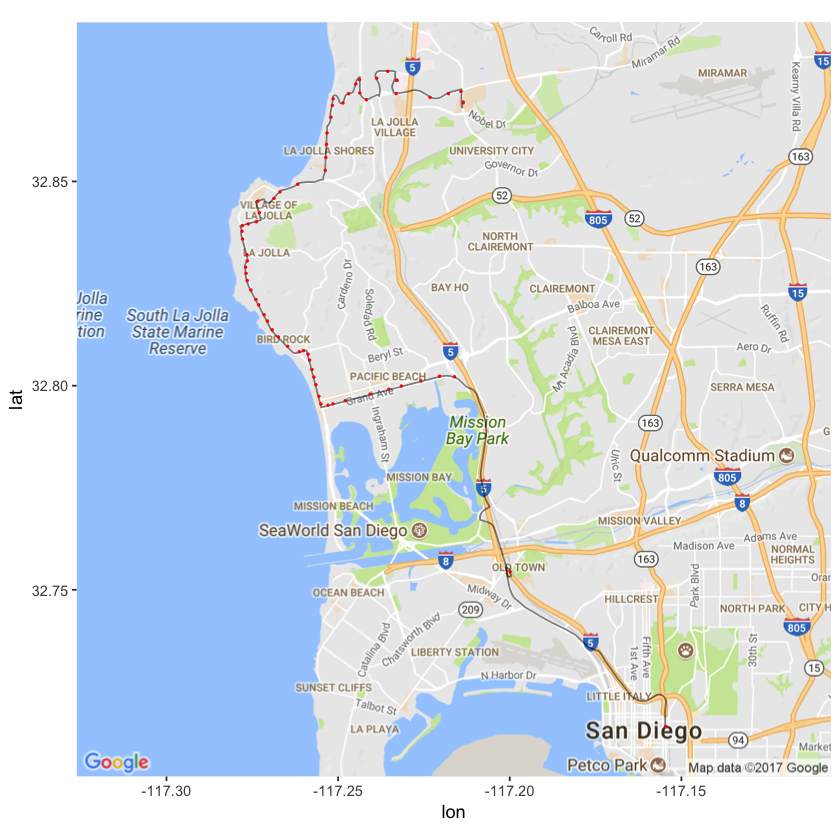

In [12]:
sq_map <- get_map(location = trip_bbox, maptype = "roadmap", source = "google")
ggmap(sq_map) + geom_path(data = trip_shape, 
                          mapping = aes(x = shape_pt_lon, y = shape_pt_lat), 
                          color = "black", alpha = 0.5) + geom_point(data = stops_on_trip, 
                                                                     mapping = aes(x = stop_lon, y = stop_lat), 
                                                                     color = "red", alpha = 1.0, size = 0.3)

To look at any route you'd like, simply change the value of "route" at the top!

# Places
The places file seems to be a list of all the major locations that SDMTS currently services.
Let's take a look at its distribution!

In [13]:
head(places)

place_id,place_name,reference_place,place_lat,place_long
10tbro,10th Ave & Broadway,,32.71620,-117.1558
10thb,10th Ave & B St,,32.71887,-117.1557
11tbro,11th Ave & Broadway,,32.71627,-117.1546
11thb,11th Ave & B St,,32.71783,-117.1546
12tS_N,Imperial Transit,12tS,32.70580,-117.1531
12tS_S,Imperial Transit,12tS,32.70564,-117.1533


In [14]:
places_size_bbox <- 0.147
places_bbox <- make_bbox(lon = places$place_lon, lat = places$place_lat, f = places_size_bbox)

Warning message:
“bounding box given to google - spatial extent only approximate.”converting bounding box to center/zoom specification. (experimental)
Source : https://maps.googleapis.com/maps/api/staticmap?center=32.899598,-116.728915&zoom=9&size=640x640&scale=2&maptype=roadmap&language=en-EN
Warning message:
“Removed 2 rows containing missing values (geom_point).”

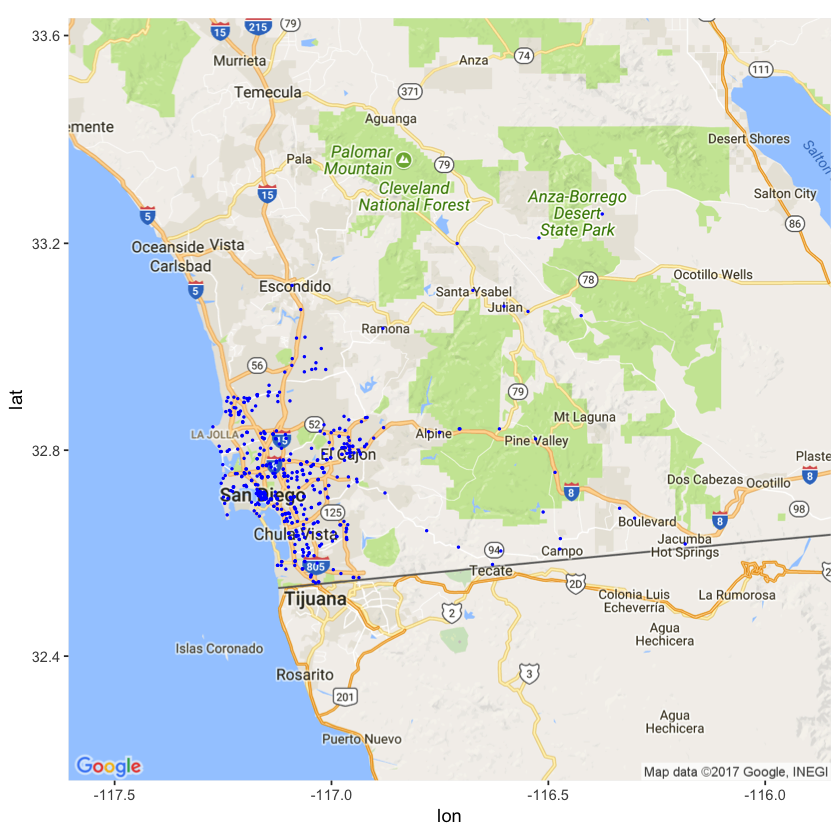

In [15]:
sq_map <- get_map(location = places_bbox, maptype = "roadmap", source = "google")
ggmap(sq_map) + geom_point(data = places, 
                           mapping = aes(x = place_long, y = place_lat), 
                           color = "blue", alpha = 1.0, size = 0.3)

The coverage of the SDMTS is quite large! However, let's focus on the primary area of service.

In [16]:
center_lat <- median(places$place_lat, na.rm = TRUE)
center_long <- median(places$place_long, na.rm = TRUE)
lat_threshold <- 0.5
long_threshold <- 0.25

In [17]:
places_primary <- places[abs(places$place_lat  - center_lat)  < lat_threshold &
                         abs(places$place_long - center_long) < long_threshold,]

In [18]:
places_primary_size_bbox <- 0.15
places_primary_bbox <- make_bbox(lon = places_primary$place_lon, lat = places_primary$place_lat, f = places_primary_size_bbox)

Warning message:
“bounding box given to google - spatial extent only approximate.”converting bounding box to center/zoom specification. (experimental)
Source : https://maps.googleapis.com/maps/api/staticmap?center=32.83073,-117.074987&zoom=11&size=640x640&scale=2&maptype=roadmap&language=en-EN
Warning message:
“Removed 81 rows containing missing values (geom_point).”

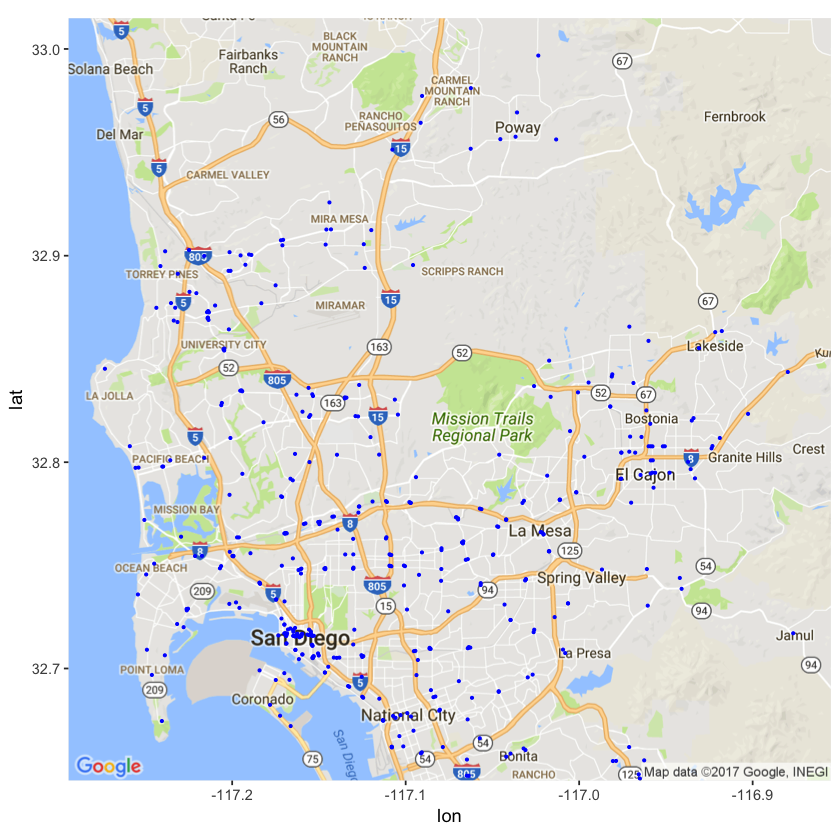

In [19]:
sq_map <- get_map(location = places_primary_bbox, maptype = "roadmap", source = "google")
ggmap(sq_map) + geom_point(data = places_primary, 
                           mapping = aes(x = place_long, y = place_lat), 
                           color = "blue", alpha = 1.0, size = 0.5)